In [37]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
data = pd.read_csv('dane_po_EDA.csv')

In [39]:
data.drop([data.columns[0]], axis=1, inplace=True)

In [40]:
data.drop(columns=['track', 'artist', 'album'], inplace=True)

In [41]:
filt = data['new genre'] != 'Other'
data = data[filt]

In [42]:
data

,artist pop,track pop,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year,new genre
0,87,71,186466,0.680,0.609,-5.222,0.0440,0.323000,0.000000,0.1020,0.325,94.350,2016,pop
1,80,83,276920,0.491,0.956,-1.538,0.3920,0.029500,0.000000,0.4600,0.811,173.585,2009,hip hop
2,82,81,265480,0.216,0.497,-8.025,0.0371,0.128000,0.000002,0.1110,0.313,187.308,2019,hip hop
3,86,81,291796,0.421,0.131,-18.435,0.0382,0.952000,0.004530,0.1090,0.120,137.446,2019,pop
4,81,80,354320,0.411,0.404,-9.928,0.0511,0.271000,0.000000,0.3000,0.226,71.068,1975,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,68,73,294600,0.320,0.880,-6.035,0.0504,0.000101,0.000004,0.0760,0.257,146.349,2001,metal
2118,53,61,236866,0.301,0.823,-4.072,0.0433,0.000144,0.000309,0.0833,0.372,152.017,2000,metal
2119,67,51,245306,0.479,0.929,-5.106,0.0921,0.002910,0.293000,0.1710,0.344,159.949,2005,rock
2120,78,76,285653,0.546,0.814,-5.146,0.0314,0.023000,0.000000,0.0972,0.146,104.980,2004,rock


In [43]:
def cor_features(df):
    highly_correlated_features = set()
    correlation_matrix = df.corr().abs()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if correlation_matrix.iloc[i, j] > 0.6:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                highly_correlated_features.add((colname_i, colname_j, correlation_matrix.iloc[i, j]))
    print("Pairs of highly correlated features:")
    for pair in highly_correlated_features:
        print(pair)


In [44]:
data_cor = data.drop([data.columns[13]], axis=1)
cor_features(data_cor)

Pairs of highly correlated features:
('loudness', 'energy', 0.7799460045774012)
('acousticness', 'energy', 0.7778653706571921)
('instrumentalness', 'loudness', 0.6734956210013407)
('acousticness', 'loudness', 0.6702157700395519)


In [45]:
columns_to_drop = ['instrumentalness', 'acousticness']
data.drop(columns=columns_to_drop, inplace=True)

In [46]:
from sklearn.preprocessing import LabelEncoder

genres = data['new genre']
label_encoder = LabelEncoder()
encoded_genres = label_encoder.fit_transform(genres)
print("Zakodowane gatunki:", encoded_genres)
for genre, code in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{genre}: {code}")
data.drop(columns='new genre', inplace=True)
data['genre'] = encoded_genres

Zakodowane gatunki: [ 9  4  4 ... 11 11  7]
blues: 0
classical: 1
dance: 2
folk: 3
hip hop: 4
indie: 5
jazz: 6
metal: 7
other: 8
pop: 9
rap: 10
rock: 11
soul: 12


In [47]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)
X_train = x_train_scaled
X_test = x_test_scaled

# LOGISTIC REGRESSION

In [53]:
from sklearn.linear_model import LogisticRegression
model_lg = LogisticRegression(random_state=42)

# RANDOM FOREST CLASSIFIER 

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model_rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],  # różne wartości liczby drzew
    'max_depth': [3, 4, 5] # głębokość 
}

grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Najlepsze parametry
print("Najlepsze parametry:", grid_search.best_params_)

# Najlepszy wynik
print("Najlepszy wynik:", grid_search.best_score_)

Najlepsze parametry: {'max_depth': 5, 'n_estimators': 50}
Najlepszy wynik: 0.5109082001730303


In [50]:
model_rf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], random_state=42)

# SVC

In [59]:
from sklearn.svm import SVC
model_svc = SVC(kernel='rbf')

# KNN

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Zakres wartości k, które chcesz sprawdzić
k_range = range(1, 30)

# Lista do przechowywania wyników
k_scores = []

# Przeprowadzenie walidacji krzyżowej dla każdej wartości k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Obliczenie średniej dokładności przy użyciu walidacji krzyżowej
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
    k_scores.append(scores.mean())

# Wydrukowanie wyników
for i, score in enumerate(k_scores):
    print(f"k={k_range[i]}, Accuracy={score:.4f}")


k=1, Accuracy=0.4549
k=2, Accuracy=0.4431
k=3, Accuracy=0.4467
k=4, Accuracy=0.4691
k=5, Accuracy=0.4773
k=6, Accuracy=0.4767
k=7, Accuracy=0.4755
k=8, Accuracy=0.4867
k=9, Accuracy=0.4873
k=10, Accuracy=0.4926
k=11, Accuracy=0.4950
k=12, Accuracy=0.4920
k=13, Accuracy=0.4867
k=14, Accuracy=0.4921
k=15, Accuracy=0.4962
k=16, Accuracy=0.4932
k=17, Accuracy=0.4938
k=18, Accuracy=0.4891
k=19, Accuracy=0.4932
k=20, Accuracy=0.4897
k=21, Accuracy=0.4944
k=22, Accuracy=0.4991
k=23, Accuracy=0.4921
k=24, Accuracy=0.4915
k=25, Accuracy=0.4897
k=26, Accuracy=0.4897
k=27, Accuracy=0.4944
k=28, Accuracy=0.4921
k=29, Accuracy=0.4968


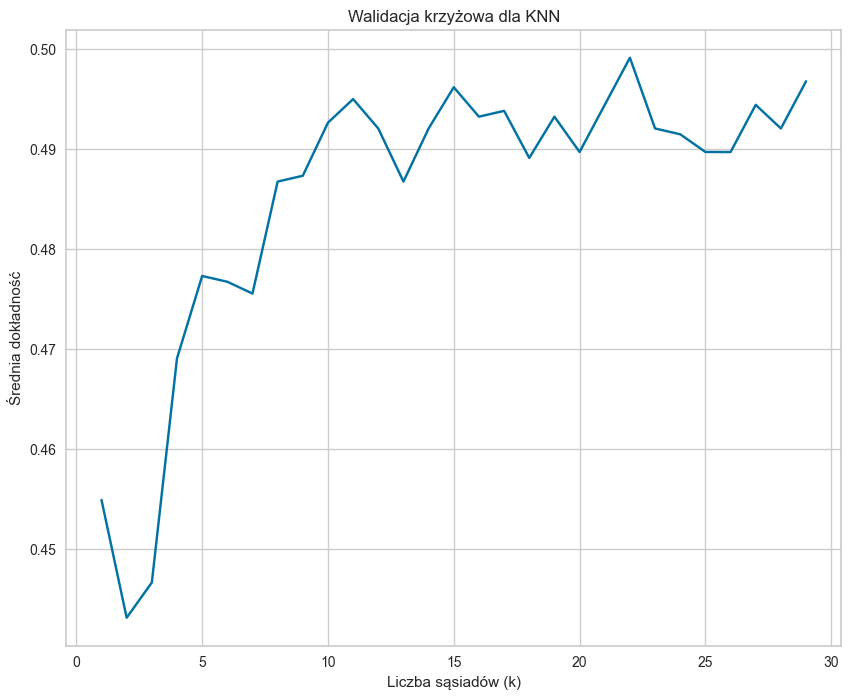

In [57]:
plt.plot(k_range, k_scores)
plt.xlabel('Liczba sąsiadów (k)')
plt.ylabel('Średnia dokładność')
plt.title('Walidacja krzyżowa dla KNN')
plt.show()

In [58]:
k = 22 
model_knn = KNeighborsClassifier(k)

# XGBOOST

In [51]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

model_xgb = XGBClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], random_state=42)

Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score: 0.5509876272970804


# MLP

In [76]:
import tensorflow as tf
from scikeras.wrappers import KerasClassifier

y_train = y_train.astype(float)
y_test = y_test.astype(float)

model_mlp = tf.keras.Sequential([
    tf.keras.Input(shape=(11,)),  # Warstwa wejściowa z 11 cechami
    tf.keras.layers.Dense(64, activation='sigmoid'),  # Ukryta warstwa
    tf.keras.layers.Dense(32, activation='sigmoid'),  # Ukryta warstwa
    tf.keras.layers.Dense(16, activation='sigmoid'),  # Ukryta warstwa
    tf.keras.layers.Dense(8, activation='sigmoid'),  # Ukryta warstwa
    tf.keras.layers.Dense(13, activation='softmax')  # Warstwa wyjściowa dla klasyfikacji binarnej
])

model_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_mlp = KerasClassifier(model=model_mlp, epochs=10, batch_size=32, verbose=0)

wzięcie tylko tych które sa okreslone gatunkiem
korelacje cech 
modele : RF, MLP, XGBOOST, LOGISTICREGRESSION, KNN, SVC 
walidacja KFold + spr overfiitingu na wykresie 
ocena : metryki recall, precision, f1, accuracy, roc,auc
spróbowanie ze SMOTE żeby zrównoważyć model

In [78]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

kf = KFold(n_splits=3, shuffle=True, random_state=42)

def score_of_model(model):
    acc_score = []

    for train_index, val_index in kf.split(X_train):
        x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model.fit(x_train_fold, y_train_fold)
        val_pred = model.predict(x_val_fold)
        acc = accuracy_score(y_val_fold, val_pred)
        acc_score.append(acc)
    return acc_score

validation_tab = pd.DataFrame(columns=['Model', 'Score 1', 'Score 2', 'Score 3'])
scores = [np.mean(score_of_model(model_lg)), np.mean(score_of_model(model_knn)), np.mean(score_of_model(model_svc)), np.mean(score_of_model(model_rf)), np.mean(score_of_model(model_xgb)), np.mean(score_of_model(model_mlp))]
models= ['logistic regression', 'KNN', 'SVC', 'random forest', 'XGBOOST', 'MLP']
validation_tab['Mean Score'] = scores
validation_tab['Model'] = models
validation_tab.iloc[0, 1:4] = score_of_model(model_lg)
validation_tab.iloc[1, 1:4] = score_of_model(model_knn)
validation_tab.iloc[2, 1:4] = score_of_model(model_svc)
validation_tab.iloc[3, 1:4] = score_of_model(model_rf)
validation_tab.iloc[4, 1:4] = score_of_model(model_xgb)
validation_tab.iloc[5, 1:4] = score_of_model(model_mlp)

validation_tab

,Model,Score 1,Score 2,Score 3,Mean Score
0,logistic regression,0.498233,0.515901,0.486726,0.500287
1,KNN,0.503534,0.496466,0.502655,0.500885
2,SVC,0.5053,0.5053,0.497345,0.502649
3,random forest,0.514134,0.512367,0.502655,0.509719
4,XGBOOST,0.575972,0.565371,0.515044,0.552129
5,MLP,0.491166,0.503534,0.472566,0.354786


C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
 

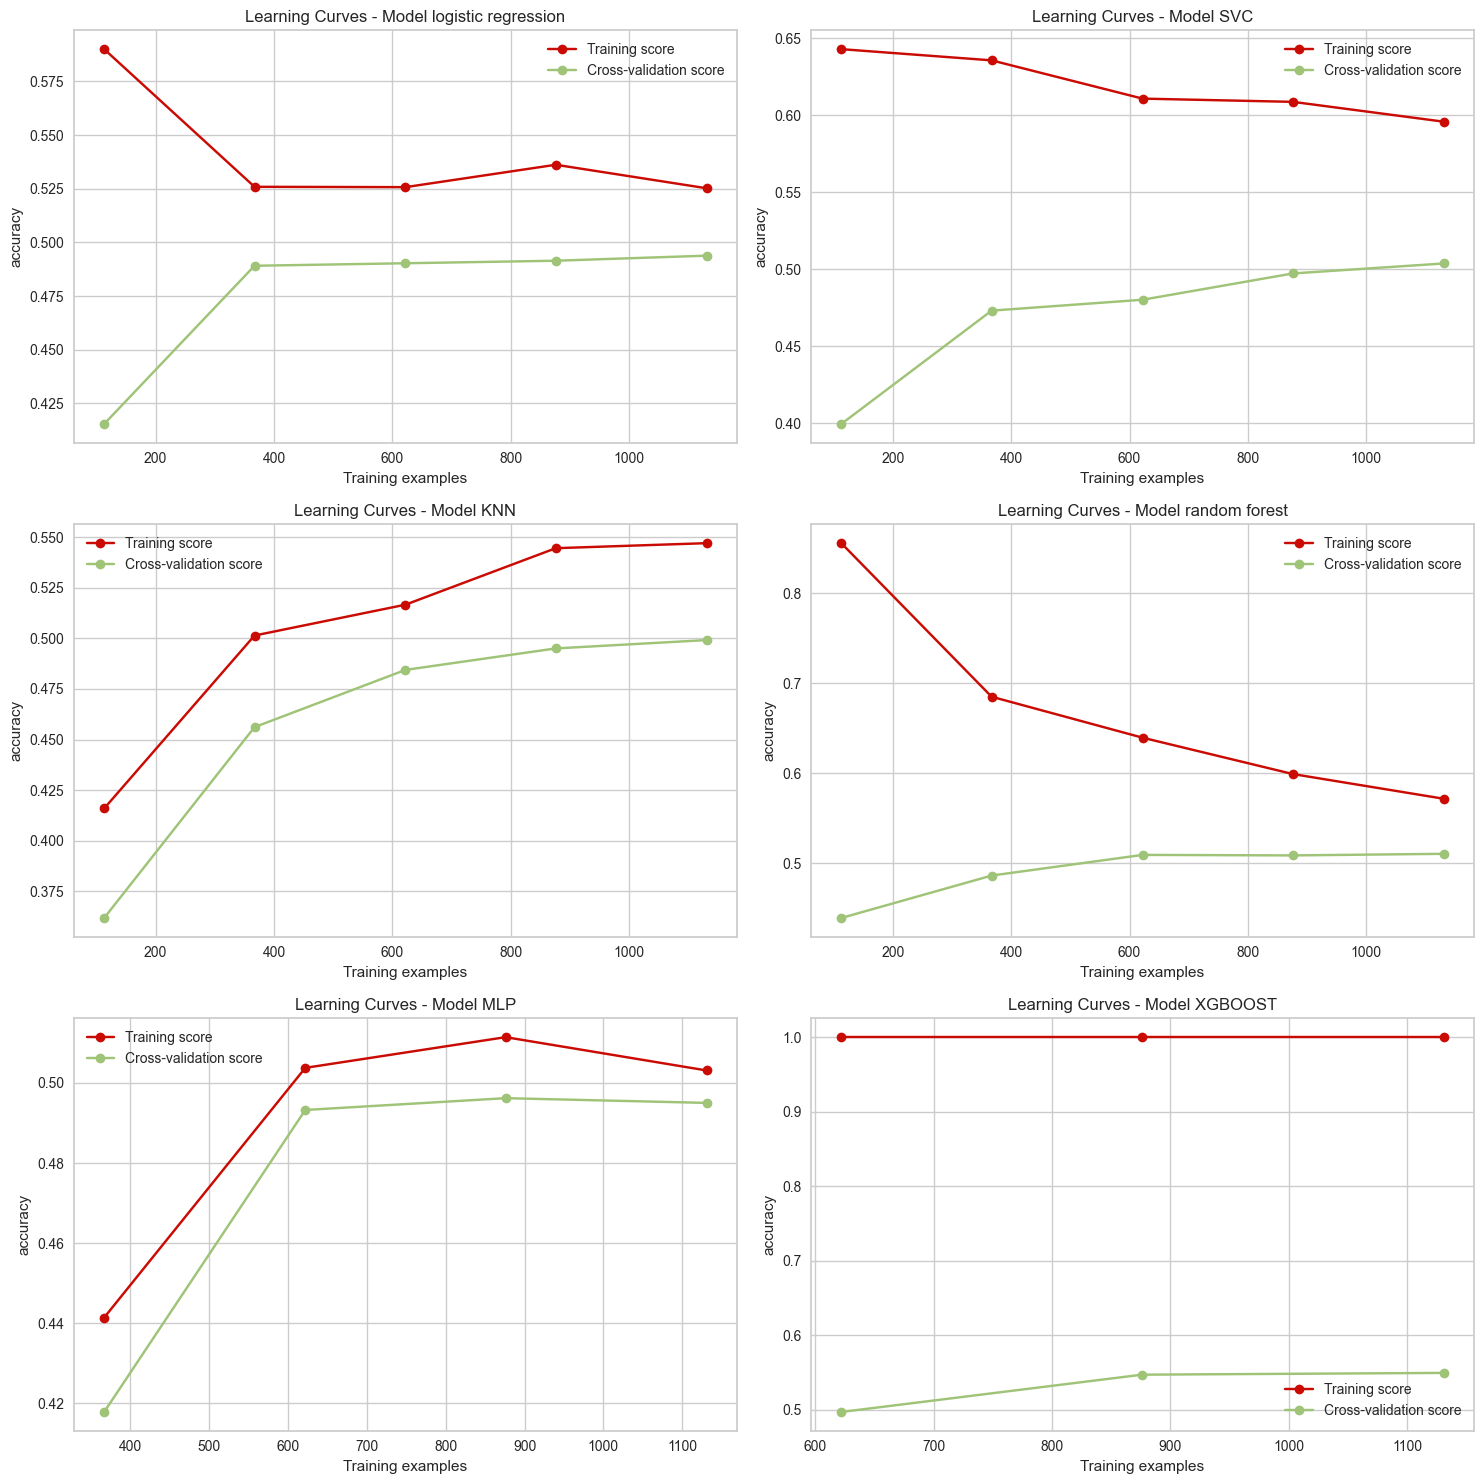

In [80]:
from sklearn.model_selection import learning_curve

def wykres_bledu(model, nazwa_modelu, ax, X=X_train, y=y_train):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=3, scoring='accuracy')
    
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
    ax.set_title(f'Learning Curves - {nazwa_modelu}')
    ax.set_xlabel('Training examples')
    ax.set_ylabel('accuracy')
    ax.legend(loc='best')

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

wykres_bledu(model_lg, 'Model logistic regression', axes[0, 0])
wykres_bledu(model_svc, 'Model SVC', axes[0, 1])
wykres_bledu(model_knn, 'Model KNN', axes[1, 0])
wykres_bledu(model_rf, 'Model random forest', axes[1, 1])
wykres_bledu(model_mlp,  'Model MLP', axes[2, 0])
wykres_bledu(model_xgb,  'Model XGBOOST', axes[2, 1])

plt.tight_layout()
plt.show()

In [86]:
model_lg.fit(X_train, y_train)
model_knn.fit(X_train, y_train)
model_svc.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
model_mlp.fit(X_train, y_train)

y_pred_lg = model_lg.predict(X_test)
y_pred_knn = model_knn.predict(X_test)
y_pred_svc = model_svc.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)
predictions = model_mlp.predict(X_test)

lista_accuracy = [accuracy_score(y_test, y_pred_lg), accuracy_score(y_test, y_pred_knn),  accuracy_score(y_test, y_pred_svc), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, predictions)]
lista_precision = [precision_score(y_test, y_pred_lg, average='weighted'), precision_score(y_test, y_pred_knn, average='weighted'),  precision_score(y_test, y_pred_svc, average='weighted'), precision_score(y_test, y_pred_rf, average='weighted'), precision_score(y_test, y_pred_xgb, average='weighted'), precision_score(y_test, predictions, average='weighted')]
lista_recall = [recall_score(y_test, y_pred_lg, average='weighted'), recall_score(y_test, y_pred_knn, average='weighted'),  recall_score(y_test, y_pred_svc,average='weighted' ), recall_score(y_test, y_pred_rf, average='weighted'), recall_score(y_test, y_pred_xgb, average='weighted'), recall_score(y_test, predictions, average='weighted')]
lista_f1 = [f1_score(y_test, y_pred_lg, average='weighted'), f1_score(y_test, y_pred_knn, average='weighted'),  f1_score(y_test, y_pred_svc, average='weighted'), f1_score(y_test, y_pred_rf, average='weighted'), f1_score(y_test, y_pred_xgb, average='weighted'), f1_score(y_test, predictions, average='weighted')]
models= ['logist regression', 'KNN', 'SVC', 'random forest', 'XGBOOST', 'MLP']

error_tab  = pd.DataFrame()
error_tab['Model'] = models
error_tab['accuracy'] = lista_accuracy
error_tab['precision'] = lista_precision
error_tab['recall'] = lista_recall
error_tab['f1'] = lista_f1

C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [87]:
error_tab

,Model,accuracy,precision,recall,f1
0,logist regression,0.468235,0.443632,0.468235,0.437191
1,KNN,0.456471,0.399972,0.456471,0.414209
2,SVC,0.465882,0.440740,0.465882,0.420496
3,random forest,0.461176,0.399839,0.461176,0.394334
4,XGBOOST,0.567059,0.573966,0.567059,0.553684
5,MLP,0.432941,0.321151,0.432941,0.364386


In [88]:
def cm_plot(cm):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [90]:
from sklearn.metrics import roc_curve, auc

def aoc_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

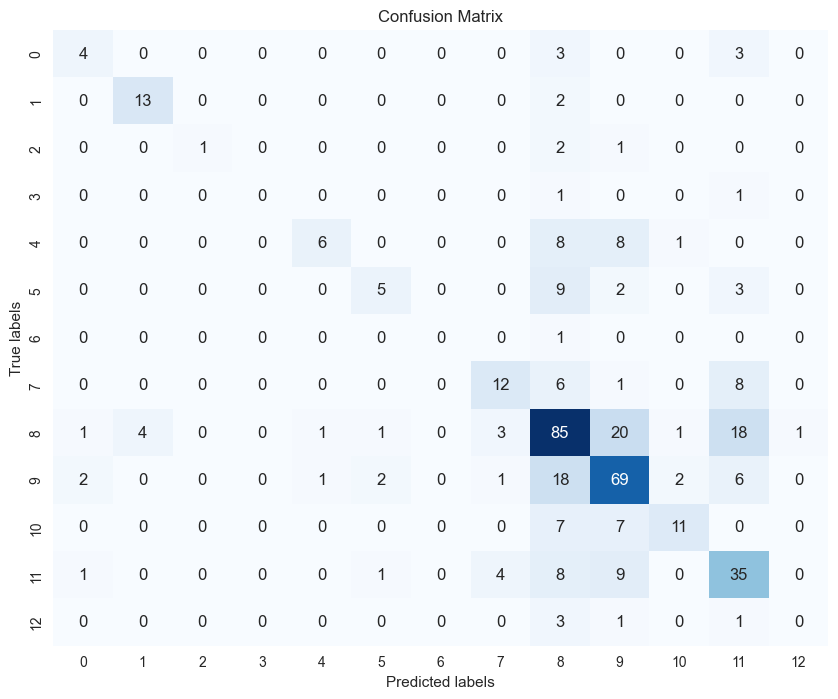

In [92]:
from sklearn import metrics

cm1 = metrics.confusion_matrix(y_test, y_pred_xgb)
cm_plot(cm1)

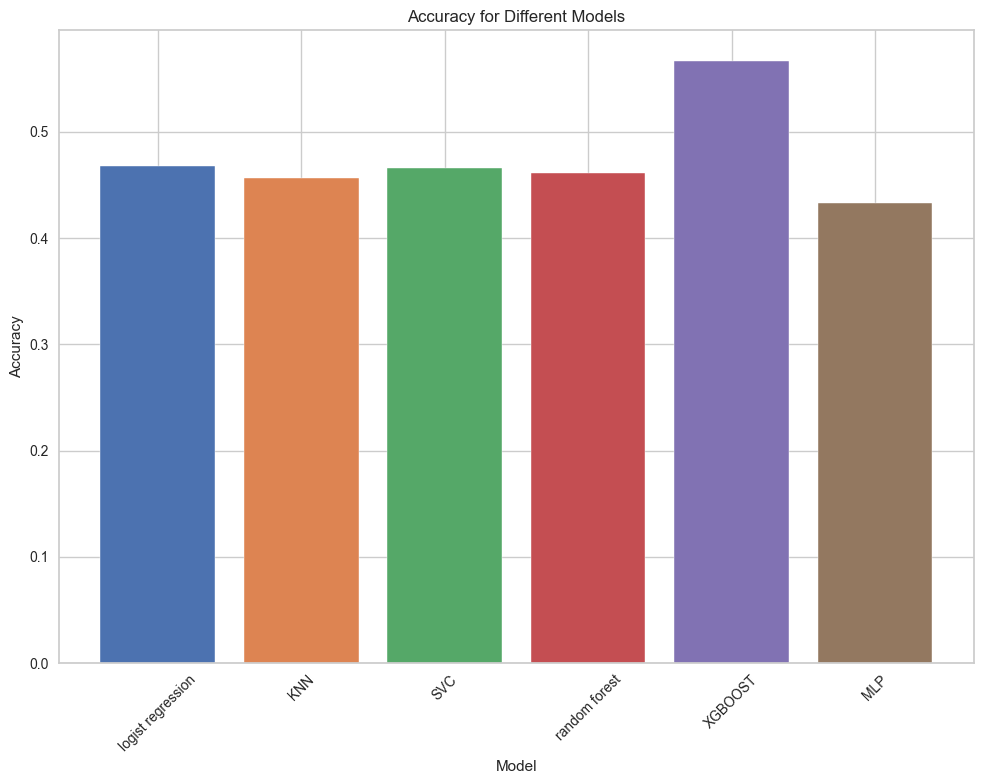

In [94]:
palette = sns.color_palette("deep", len(error_tab))
plt.bar(error_tab['Model'], error_tab['accuracy'], color=palette)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')
plt.xticks(rotation=45)
plt.tight_layout()